# Virtual bidding in NYISO's markets


In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [2]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [3]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [4]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [45]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4
Classifier trained for option CENTRL_Hour_5
Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15
Classifier trained for option CENTRL_Hour_16
Classifier trained for option CENTRL_Hour_17


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19
Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21
Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23
Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2
Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_5


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_6


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_9


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_10
Classifier trained for option DUNWOD_Hour_11


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_17


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_18


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option DUNWOD_Hour_19
Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23
Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_2


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_3
Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_6
Classifier trained for option GENESE_Hour_7


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10
Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12
Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14
Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_17


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19
Classifier trained for option GENESE_Hour_20
Classifier trained for option GENESE_Hour_21
Classifier trained for option GENESE_Hour_22
Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1
Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15
Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17
Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_20


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_21
Classifier trained for option HUD VL_Hour_22


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option HUD VL_Hour_23


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_0
Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_3
Classifier trained for option LONGIL_Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_5
Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_8


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_11
Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16
Classifier trained for option LONGIL_Hour_17


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option LONGIL_Hour_18
Classifier trained for option LONGIL_Hour_19
Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21
Classifier trained for option LONGIL_Hour_22
Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_2
Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_6


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12
Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_15
Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17
Classifier trained for option MHK VL_Hour_18
Classifier trained for option MHK VL_Hour_19


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_20


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MHK VL_Hour_21
Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23
Classifier trained for option MILLWD_Hour_0
Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_5
Classifier trained for option MILLWD_Hour_6
Classifier trained for option MILLWD_Hour_7


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_8
Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_11
Classifier trained for option MILLWD_Hour_12


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_13


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_18


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22
Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4
Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_7
Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9
Classifier trained for option NORTH_Hour_10


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_11
Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_14
Classifier trained for option NORTH_Hour_15


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_16
Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_19


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21
Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23
Classifier trained for option WEST_Hour_0


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_5


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_6
Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8
Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11
Classifier trained for option WEST_Hour_12
Classifier trained for option WEST_Hour_13
Classifier trained for option WEST_Hour_14
Classifier trained for option WEST_Hour_15
Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17
Classifier trained for option WEST_Hour_18
Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20


C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.95 percent.


### Test the classifier's accuracy on test data.

In [46]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 49.86%, Avg = 58.98%, Max = 72.45%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [47]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -79,914
Day 4: Reward (in $) = 3,047,816
Day 5: Reward (in $) = 24,004
Day 6: Reward (in $) = -48,232
Day 7: Reward (in $) = -4,390
Day 8: Reward (in $) = -45,896
Day 9: Reward (in $) = -29,683
Day 10: Reward (in $) = -115,252
Day 11: Reward (in $) = -82,285
Day 12: Reward (in $) = -80,712
Day 13: Reward (in $) = -70,541
Day 14: Reward (in $) = -41,851
Day 15: Reward (in $) = -9,903
Day 16: Reward (in $) = 38,882
Day 17: Reward (in $) = -65,900
Day 18: Reward (in $) = -27,079
Day 19: Reward (in $) = 5,218
Day 20: Reward (in $) = -6,108
Day 21: Reward (in $) = 27,212
Day 22: Reward (in $) = 86,513
Day 23: Reward (in $) = 29,220
Day 24: Reward (in $) = -80,990
Day 25: Reward (in $) = -21,767
Day 26: Reward (in $) = -16,805
Day 27: Reward (in $) = -11,849
Day 28: Reward (in $) = -21,746
Day 29: Reward (in $) = -23,209
Day 30: Reward (in $) = -59,282
Day 31: Reward (in $) = -26,292
Day 32: Reward (in $) = -8,081
Day 33: Reward (in $) = -70,054
Day 34: Reward (in $) =

Day 259: Reward (in $) = -40,183
Day 260: Reward (in $) = -25,864
Day 261: Reward (in $) = 22,016
Day 262: Reward (in $) = 7,910
Day 263: Reward (in $) = -25,917
Day 264: Reward (in $) = -35,415
Day 265: Reward (in $) = -6,316
Day 266: Reward (in $) = -69,443
Day 267: Reward (in $) = -8,338
Day 268: Reward (in $) = -22,863
Day 269: Reward (in $) = -83,327
Day 270: Reward (in $) = -86,615
Day 271: Reward (in $) = -10,904
Day 272: Reward (in $) = -32,246
Day 273: Reward (in $) = -31,744
Day 274: Reward (in $) = 13,106
Day 275: Reward (in $) = 23,739
Day 276: Reward (in $) = 49,395
Day 277: Reward (in $) = 136,096
Day 278: Reward (in $) = 183,349
Day 279: Reward (in $) = 51,910
Day 280: Reward (in $) = 11,881
Day 281: Reward (in $) = -9,677
Day 282: Reward (in $) = -3,431
Day 283: Reward (in $) = -3,043
Day 284: Reward (in $) = 19,975
Day 285: Reward (in $) = -61,479
Day 286: Reward (in $) = -50,873
Day 287: Reward (in $) = -41,035
Day 288: Reward (in $) = 12,624
Day 289: Reward (in $) = 

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


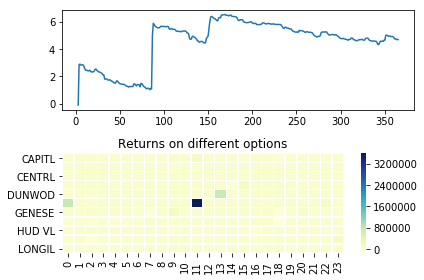

In [34]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs = axs.ravel()


## Enter code here where you plot in axs[0].
axs[0].plot(cumulativeReward.keys(), cumulativeReward.values() ) 
axs[1] = sns.heatmap(np.reshape(list(optionReturn.values()), (len(listOfZones), 24)),
                     linewidth=0.5,
                     cmap="YlGnBu")
axs[1].set_yticklabels(listOfZones, rotation=0)
axs[1].set_xticklabels(range(24), rotation=90)
axs[1].set_title('Returns on different options')
plt.show()


### Task 2: Choosing a classifier (25 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

#### Using MLP 
<br>Test Accuracy Stats: Min = 47.66%, Avg = 58.78%, Max = 69.70%</br>
<br>Total money earned over the year (in $) = 8,063,347</br>

#### Using SVM (RBF) 
<br>Test Accuracy Stats: Min = 49.86%, Avg = 65.57%, Max = 76.31%</br> 
<br>Total money earned over the year (in $) = 1,070,234</br> 

#### Using Logistic Regression 
<br>Test Accuracy Stats: Min = 46.56%, Avg = 57.11%, Max = 66.94%</br>
<br>Total money earned over the year (in $) = 3,191,907</br>

In [86]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.

    # SVC( degree = 3, kernel = 'rbf' )
    #LogisticRegression( penalty = 'l2', solver = 'liblinear' )
    
    classifiers = [ SVC( degree = 3, kernel = 'rbf', max_iter = 100000 )
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    # print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    # print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    # print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained f

In [87]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 49.86%, Avg = 65.57%, Max = 76.31%


In [43]:
dailyBudget = 250000
quantileOffer =0.80

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -67,771
Day 4: Reward (in $) = 1,474,679
Day 5: Reward (in $) = 24,912
Day 6: Reward (in $) = -12,113
Day 7: Reward (in $) = -33,755
Day 8: Reward (in $) = 1,285
Day 9: Reward (in $) = -40,245
Day 10: Reward (in $) = -104,691
Day 11: Reward (in $) = -66,352
Day 12: Reward (in $) = -19,281
Day 13: Reward (in $) = -28,826
Day 14: Reward (in $) = -37,943
Day 15: Reward (in $) = -531
Day 16: Reward (in $) = 41,759
Day 17: Reward (in $) = -68,051
Day 18: Reward (in $) = -22,119
Day 19: Reward (in $) = 14,669
Day 20: Reward (in $) = -6,074
Day 21: Reward (in $) = 30,659
Day 22: Reward (in $) = 125,346
Day 23: Reward (in $) = 27,844
Day 24: Reward (in $) = -86,351
Day 25: Reward (in $) = -88,326
Day 26: Reward (in $) = -18,248
Day 27: Reward (in $) = -7,270
Day 28: Reward (in $) = -12,538
Day 29: Reward (in $) = -21,999
Day 30: Reward (in $) = -34,914
Day 31: Reward (in $) = -47,259
Day 32: Reward (in $) = -11,417
Day 33: Reward (in $) = -57,878
Day 34: Reward (in $) = 

Day 259: Reward (in $) = -39,138
Day 260: Reward (in $) = -31,092
Day 261: Reward (in $) = 68,688
Day 262: Reward (in $) = -8,606
Day 263: Reward (in $) = -61,880
Day 264: Reward (in $) = -40,526
Day 265: Reward (in $) = -4,663
Day 266: Reward (in $) = -87,739
Day 267: Reward (in $) = -8,703
Day 268: Reward (in $) = -22,362
Day 269: Reward (in $) = -84,037
Day 270: Reward (in $) = -70,217
Day 271: Reward (in $) = -8,869
Day 272: Reward (in $) = -25,087
Day 273: Reward (in $) = -42,839
Day 274: Reward (in $) = 22,621
Day 275: Reward (in $) = 23,373
Day 276: Reward (in $) = -20,355
Day 277: Reward (in $) = 73,821
Day 278: Reward (in $) = 141,076
Day 279: Reward (in $) = 803
Day 280: Reward (in $) = -26,410
Day 281: Reward (in $) = -11,458
Day 282: Reward (in $) = 12,581
Day 283: Reward (in $) = -5,498
Day 284: Reward (in $) = -33,155
Day 285: Reward (in $) = 17,325
Day 286: Reward (in $) = -54,204
Day 287: Reward (in $) = -61,896
Day 288: Reward (in $) = 4,166
Day 289: Reward (in $) = 5,

### Task 3: Quantile (25 points)

For the best classifier, try different quanltile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

#### (comments here, add a new code cell below)
<br>Q = 0.70 : 6,932,325 </br>
<br>Q = 0.75 : 9,051,338 </br> 
<br>Q = 0.80 : 8,136,625 </br>
<br>Q = 0.85 : 6,703,334 </br>
<br>Q = 0.90 : 4,836,639 </br> 
<br>Q = 0.95 : 3,940,849 </br> 

<br> Having a different quantile level determines how high the user will bid given the price is within the previous years quantile region. The higher the quantile level, the more higher the user will bid while at a lower quantile value will yield the person bidding at a lower amount. The highest quantile yielded the lowest value while a quantile level between 0.70 - 0.80 seemed to yield good amounts. This made sense as bidding at a 95% quantile will likely lead having a smaller gap between the equlibirum price and the offered price. Thus we should set our quantile level between 0.7 and 0.8 as they seem to be reasonable quantile levels to bid on. </br> 

In [53]:
dailyBudget = 250000
quantileOffer = 0.95

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -14,447
Day 4: Reward (in $) = 1,902,413
Day 5: Reward (in $) = 17,363
Day 6: Reward (in $) = -41,342
Day 7: Reward (in $) = -2,829
Day 8: Reward (in $) = -27,956
Day 9: Reward (in $) = -18,355
Day 10: Reward (in $) = -74,308
Day 11: Reward (in $) = -51,577
Day 12: Reward (in $) = -47,153
Day 13: Reward (in $) = -45,300
Day 14: Reward (in $) = -24,659
Day 15: Reward (in $) = -5,882
Day 16: Reward (in $) = 22,776
Day 17: Reward (in $) = -40,329
Day 18: Reward (in $) = -18,165
Day 19: Reward (in $) = 4,531
Day 20: Reward (in $) = -5,144
Day 21: Reward (in $) = 16,887
Day 22: Reward (in $) = 53,612
Day 23: Reward (in $) = 21,422
Day 24: Reward (in $) = -53,717
Day 25: Reward (in $) = -9,044
Day 26: Reward (in $) = -9,728
Day 27: Reward (in $) = -5,405
Day 28: Reward (in $) = -14,391
Day 29: Reward (in $) = -14,973
Day 30: Reward (in $) = -30,078
Day 31: Reward (in $) = -13,637
Day 32: Reward (in $) = -4,991
Day 33: Reward (in $) = -44,144
Day 34: Reward (in $) = -6,

Day 258: Reward (in $) = -6,595
Day 259: Reward (in $) = -20,504
Day 260: Reward (in $) = -10,876
Day 261: Reward (in $) = 9,579
Day 262: Reward (in $) = -1,415
Day 263: Reward (in $) = -32,770
Day 264: Reward (in $) = -65,739
Day 265: Reward (in $) = -4,685
Day 266: Reward (in $) = -52,872
Day 267: Reward (in $) = -4,928
Day 268: Reward (in $) = -14,294
Day 269: Reward (in $) = -51,681
Day 270: Reward (in $) = -51,268
Day 271: Reward (in $) = -5,381
Day 272: Reward (in $) = -15,030
Day 273: Reward (in $) = -15,101
Day 274: Reward (in $) = 6,287
Day 275: Reward (in $) = 14,469
Day 276: Reward (in $) = 25,001
Day 277: Reward (in $) = 68,543
Day 278: Reward (in $) = 108,481
Day 279: Reward (in $) = 22,984
Day 280: Reward (in $) = 5,119
Day 281: Reward (in $) = -4,461
Day 282: Reward (in $) = -1,522
Day 283: Reward (in $) = -80,715
Day 284: Reward (in $) = 8,969
Day 285: Reward (in $) = -35,134
Day 286: Reward (in $) = -28,449
Day 287: Reward (in $) = -23,347
Day 288: Reward (in $) = 7,76

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

#### (comments here, add a new code cell below)
<br>Daily Budget = 100,000 : 3,632,160</br> 
<br>Daily Budget = 150,000 : 5,456,777</br>
<br>Daily Budget = 200,000 : 7,228,041</br>
<br>Daily Budget = 300,000 : 10,899,459</br>


In [58]:
dailyBudget = 300000
quantileOffer = 0.75

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]
    
    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -88,069
Day 4: Reward (in $) = 3,894,773
Day 5: Reward (in $) = 31,218
Day 6: Reward (in $) = -59,442
Day 7: Reward (in $) = -3,356
Day 8: Reward (in $) = -56,261
Day 9: Reward (in $) = -38,559
Day 10: Reward (in $) = -144,120
Day 11: Reward (in $) = -99,857
Day 12: Reward (in $) = -103,065
Day 13: Reward (in $) = -85,624
Day 14: Reward (in $) = -51,712
Day 15: Reward (in $) = -12,276
Day 16: Reward (in $) = 46,067
Day 17: Reward (in $) = -83,714
Day 18: Reward (in $) = -34,674
Day 19: Reward (in $) = 4,453
Day 20: Reward (in $) = -8,682
Day 21: Reward (in $) = 34,920
Day 22: Reward (in $) = 107,150
Day 23: Reward (in $) = 36,330
Day 24: Reward (in $) = -102,756
Day 25: Reward (in $) = -35,203
Day 26: Reward (in $) = -22,455
Day 27: Reward (in $) = -15,325
Day 28: Reward (in $) = -27,644
Day 29: Reward (in $) = -30,371
Day 30: Reward (in $) = -78,556
Day 31: Reward (in $) = -34,170
Day 32: Reward (in $) = -10,426
Day 33: Reward (in $) = -89,519
Day 34: Reward (in

Day 259: Reward (in $) = -53,332
Day 260: Reward (in $) = -36,631
Day 261: Reward (in $) = 27,432
Day 262: Reward (in $) = 12,445
Day 263: Reward (in $) = -33,103
Day 264: Reward (in $) = -41,163
Day 265: Reward (in $) = -5,949
Day 266: Reward (in $) = -21,852
Day 267: Reward (in $) = -10,035
Day 268: Reward (in $) = -28,738
Day 269: Reward (in $) = -104,879
Day 270: Reward (in $) = -109,768
Day 271: Reward (in $) = -13,794
Day 272: Reward (in $) = -42,492
Day 273: Reward (in $) = -42,903
Day 274: Reward (in $) = 18,329
Day 275: Reward (in $) = 30,277
Day 276: Reward (in $) = 63,224
Day 277: Reward (in $) = 174,519
Day 278: Reward (in $) = 235,593
Day 279: Reward (in $) = 71,986
Day 280: Reward (in $) = 17,472
Day 281: Reward (in $) = -12,897
Day 282: Reward (in $) = -4,758
Day 283: Reward (in $) = -3,776
Day 284: Reward (in $) = 27,425
Day 285: Reward (in $) = -78,222
Day 286: Reward (in $) = -64,710
Day 287: Reward (in $) = -53,729
Day 288: Reward (in $) = 16,092
Day 289: Reward (in 

### Task 6: Beat the algorithm! (25 points, bonus) 

Make changes to increase the profits further! The people with the top 20 total profits will get additional points. Exaplain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)
Total money earned over the year (in $) = 8,108,141


In [85]:
dailyBudget = 250000
quantileOffer = 0.75

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]
    
    # Edit to change the Quantile based on whether Reward is Positive or not 
    if reward[day] <= -100000 and quantileOffer > 0.70 : 
        quantileOffer -= 0.05
        quantileOffer = np.around(quantileOffer, 2)
    
    if reward[day] >= 10000 and quantileOffer < 0.80 :
        quantileOffer += 0.1
        quantileOffer = np.around(quantileOffer, 2)
    
    if reward[day] <= -100000 and dailyBudget > 100000 : 
        dailyBudget -= 10000 
        
    if reward[day] >= 100000 and dailyBudget < 250000 : 
        dailyBudget += 10000     

    
    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -73,971
Day 4: Reward (in $) = 3,243,691
Day 5: Reward (in $) = 21,459
Day 6: Reward (in $) = -70,558
Day 7: Reward (in $) = -4,361
Day 8: Reward (in $) = -42,408
Day 9: Reward (in $) = -25,480
Day 10: Reward (in $) = -104,479
Day 11: Reward (in $) = -77,953
Day 12: Reward (in $) = -78,256
Day 13: Reward (in $) = -67,494
Day 14: Reward (in $) = -39,942
Day 15: Reward (in $) = -8,844
Day 16: Reward (in $) = 35,693
Day 17: Reward (in $) = -62,604
Day 18: Reward (in $) = -26,495
Day 19: Reward (in $) = 5,312
Day 20: Reward (in $) = -6,000
Day 21: Reward (in $) = 25,897
Day 22: Reward (in $) = 85,329
Day 23: Reward (in $) = 28,457
Day 24: Reward (in $) = -77,692
Day 25: Reward (in $) = -21,072
Day 26: Reward (in $) = -17,079
Day 27: Reward (in $) = -11,051
Day 28: Reward (in $) = -20,702
Day 29: Reward (in $) = -22,177
Day 30: Reward (in $) = -56,101
Day 31: Reward (in $) = -25,314
Day 32: Reward (in $) = -7,820
Day 33: Reward (in $) = -68,065
Day 34: Reward (in $) =

Day 259: Reward (in $) = -39,570
Day 260: Reward (in $) = -26,795
Day 261: Reward (in $) = 19,451
Day 262: Reward (in $) = 8,738
Day 263: Reward (in $) = -26,111
Day 264: Reward (in $) = -36,032
Day 265: Reward (in $) = -6,278
Day 266: Reward (in $) = -67,997
Day 267: Reward (in $) = -8,206
Day 268: Reward (in $) = -23,134
Day 269: Reward (in $) = -83,074
Day 270: Reward (in $) = -86,865
Day 271: Reward (in $) = -9,653
Day 272: Reward (in $) = -32,584
Day 273: Reward (in $) = -31,743
Day 274: Reward (in $) = 12,809
Day 275: Reward (in $) = 23,874
Day 276: Reward (in $) = 48,594
Day 277: Reward (in $) = 136,224
Day 278: Reward (in $) = 181,064
Day 279: Reward (in $) = 52,827
Day 280: Reward (in $) = 12,347
Day 281: Reward (in $) = -9,543
Day 282: Reward (in $) = -2,700
Day 283: Reward (in $) = -3,066
Day 284: Reward (in $) = 21,191
Day 285: Reward (in $) = -61,005
Day 286: Reward (in $) = -50,121
Day 287: Reward (in $) = -42,061
Day 288: Reward (in $) = 12,854
Day 289: Reward (in $) = 2

### Task 7: Implement a different trading strategy (25 points, bonus) 

Implement a different trading strategy, explain it and report its outcomes. If the rewards are comparable to the one discussed in class, and you can clearly explain the logic behind you strategy, you get additional 25 points. If your strategy leads to having profits among the top 20, then you automatically completed Task 6 too! 

#### (comments here, add a new code cell below)

<br>There are 2 trading strategies that I thought could be done here: Instead of taking the average for the entire year, the average can be taken for several months or changing the quantile variable based on the amount of profit earned. The reason why taking an average for several months would yield better results would be due to market not being consistent for the entire year. There will be some parts of the years where there will be a higher power demand compared to another part of a year and thus by taking only an average of within a few weeks of the current day could lead us to a better estimation of the price for that day. </br>

<br> Secondly, the other strategy that I thought of could be to change the budget/quantile based on the profit earned on that day. If the profit ended up being lower than a given threshold, we could then penalize this decision by loweirng the quantile and budget amount. On the other hand if we earn more than a given threshold, we could then increase our quantile and budget. In the implementation above, the case in which we earn a high profit will be rewarded more than a penalization due to a large amount of small losses over the days. </br> 